# OpenFOAM Centerline profile plots

Plot the centerline profiles of variables extracted from Paraview.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 Monash University
    @license GPL-3.0+
    @version 0.0.1
    @date 31/07/2024

    Department of Mechanical & Aerospace Engineering
    Monash University, Australia


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os, natsort

%matplotlib widget

In [2]:
file_list = glob.glob("/Users/dduke/Desktop/centerline/*.csv")
F=file_list[5]
print(os.path.basename(F))
plt_title="Centerline: R-134a + 15% w/w Ethanol"

ures_134a15pc_centerline.csv


In [3]:
def load_csv(f):
    with open(f,'r') as fh:
        header=fh.readline()
        varnames=header.strip().replace('"','').split(',')
    arr = np.genfromtxt(f,delimiter=',',skip_header=1)
    arrDict={}
    for i in range(len(varnames)):
        #print(i,varnames[i])
        arrDict[varnames[i]]=arr[:,i]
    return arrDict, varnames

a,v=load_csv(F)
print(v)

['DxDt', 'K', 'M', 'MSave', 'Mach:0', 'Mach:1', 'Mach:2', 'OmegaMin', 'OmegaP', 'ScLimited', 'Sigma', 'T', 'TMean', 'TPrime2Mean', 'U:0', 'U:1', 'U:2', 'UMean:0', 'UMean:1', 'UMean:2', 'UPrime2Mean:0', 'UPrime2Mean:1', 'UPrime2Mean:2', 'UPrime2Mean:3', 'UPrime2Mean:4', 'UPrime2Mean:5', 'V', 'Ybar', 'alphaFrac', 'alphaFracMean', 'alphaFracPrime2Mean', 'alphaFracStar', 'alphaSgs', 'd32', 'd32Mean', 'd32Prime2Mean', 'd32adj', 'dMdp', 'deltaRhoOnRho', 'h', 'k', 'kMean', 'kPrime2Mean', 'muSgs', 'nD', 'nDMean', 'nDPrime2Mean', 'nDnorm', 'p', 'pMean', 'pNorm', 'pPrime2Mean', 'pSat', 'p_bar', 'psi2phase', 'psi2phaseMean', 'psi2phasePrime2Mean', 'rho', 'rhoBar', 'rhoL', 'rhoMean', 'rhoPrime2Mean', 'rhoV', 'rhog', 'theta', 'x', 'xMean', 'xPrime2Mean', 'xbar', 'y', 'yMean', 'yPrime2Mean', 'vtkValidPointMask', 'arc_length', 'Points:0', 'Points:1', 'Points:2']


In [4]:
# Independent spatial variable, with zero at orifice exit.
i0=np.where(np.abs(a['Points:1'])==np.nanmin(np.abs(a['Points:1'])))
x=(a['arc_length'] - a['arc_length'][i0])*1e3

# Calculate vector magnitudes
MachMag=np.sqrt(a['Mach:0']**2 + a['Mach:1']**2 + a['Mach:2']**2)
UMag=np.sqrt(a['UMean:0']**2 + a['UMean:1']**2 + a['UMean:2']**2)

# Calculate mixture properties
Tmix = a['TMean']*(1-a['yMean']) + 297*a['yMean']
pRatio = a['pMean']/a['pSat']

# Smoothing func.
def sm(x,y,w=100): 
    window = np.hanning(w)
    window /= np.sum(window)
    # Mask NaN from y
    i=np.where(~np.isnan(y))
    # Limit range of x
    x_new = x[i][int(w/2):int(-w/2)+1]
    return x_new, np.convolve(y[i], window, 'valid')

## Plot many vars for one propellant sample

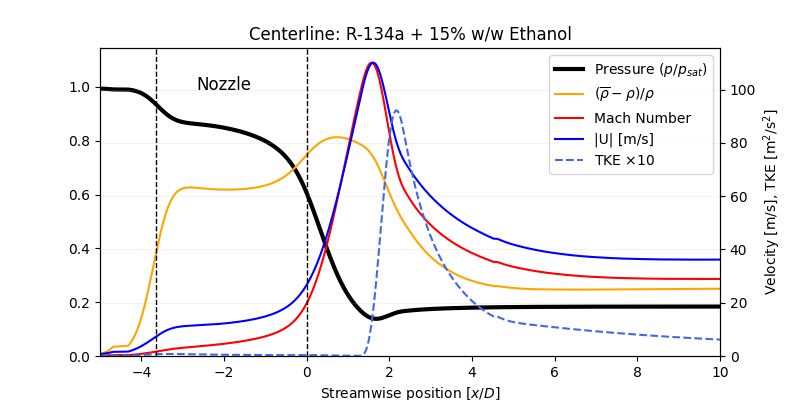

In [5]:
fig=plt.figure(figsize=(8,4))

plt.title(plt_title)
plt.xlabel('Streamwise position [$x/D$]')

p1,=plt.plot(*sm(x/.33,pRatio), label=r'Pressure ($p/p_{sat}$)',color='black',lw=3)
p2,=plt.plot(*sm(x/.33,-a['deltaRhoOnRho']),label=r'$(\overline{\rho}-\rho)/ \rho$',c='orange')
p3,=plt.plot(*sm(x/.33,MachMag), label='Mach Number',c='r')

plt.ylim(0,)
ax2=plt.gca().twinx()
p4,=ax2.plot(*sm(x/.33,UMag), label='|U| [m/s]',color='blue')
p5,=ax2.plot(*sm(x/.33,10*a['kMean']),label=r'TKE $\times 10$',color='royalblue',ls='--')

plt.grid(alpha=.15)
plt.ylabel(r'$p/p_{sat}$, $(\overline{\rho}-\rho)/ \rho$, Ma [-]')
plt.xlim(-5,10);

plt.axvline(0,c='k',lw=1,ls='--')
plt.axvline(-1.2/0.33,c='k',lw=1,ls='--')
plt.text(-2,100,"Nozzle",horizontalalignment='center',fontsize=12);
plt.ylim(0,)
plt.ylabel(r'Velocity [m/s], TKE [m$^2$/s$^2$]')

ll=[p1,p2,p3,p4,p5]
plt.legend(ll,[l.get_label() for l in ll])
plt.show();
plt.savefig(os.path.dirname(F)+'/'+plt_title.replace('/','')+' plot1.pdf')

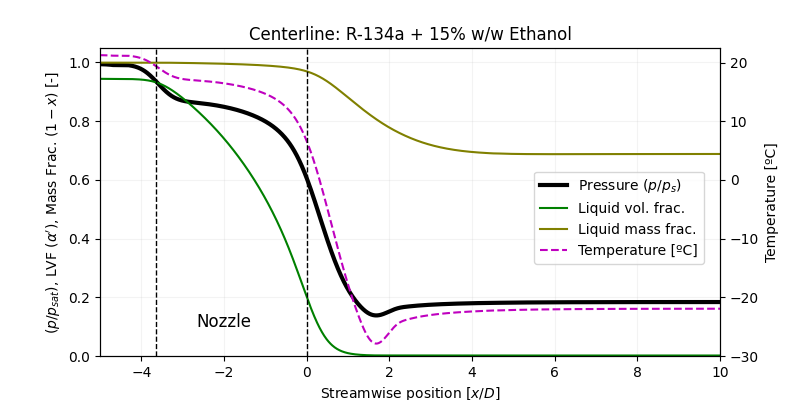

In [6]:
#ax2=plt.gca().twinx()
fig=plt.figure(figsize=(8,4))
plt.title(plt_title)
plt.xlabel('Streamwise position [$x/D$]')

plt.grid(alpha=.15)
plt.xlim(-5,10);

p1,=plt.plot(*sm(x/.33,pRatio), label=r'Pressure ($p/p_s$)',color='black',lw=3)
p6,=plt.plot(*sm(x/.33,1-a['alphaFracStar']), label=r'Liquid vol. frac.',color='green')
p7,=plt.plot(*sm(x/.33,1-a['xMean']), label=r'Liquid mass frac.',color='olive')
plt.ylim(0,)

plt.ylabel(r"$(p/p_{sat})$, LVF $(\alpha')$, Mass Frac. $(1-x)$ [-]")

ax2=plt.gca().twinx()
p8,=ax2.plot(*sm(x/.33,Tmix-273.15), label='Temperature [ºC]',c='m',ls='--')
plt.ylabel('Temperature [ºC]')
plt.ylim(-30,22.5)

plt.axvline(0,c='k',lw=1,ls='--')
plt.axvline(-1.2/0.33,c='k',lw=1,ls='--')
plt.text(-2,-25,"Nozzle",horizontalalignment='center',fontsize=12);


ll=[p1,p6,p7,p8]
plt.legend(ll,[l.get_label() for l in ll],loc=(.7,.3))

plt.show();
plt.savefig(os.path.dirname(F)+'/'+plt_title.replace('/','')+' plot2.pdf')

## Plot comparing propellants

In [72]:
def plot_a_variable(var,yLabel=None,yText=1):

    fig=plt.figure(figsize=(8,4))
    plt.xlabel('Streamwise position [$x/D$]')
    plt.grid(alpha=.15)
    
    for F in natsort.natsorted(file_list):
    
        ls='-'
        c='k'
        
        # Name for dataset
        fn=os.path.splitext(os.path.basename(F))[0]
        if '134a' in fn: l='R-134a'
        elif '152a' in fn:
            l='R-152a'
            c='r'
        elif '1234' in fn:
            l='R-1234ze(E)'
            c='b'
        else:
            l='R-227ea'
            c='c'
        if '15pc' in fn: 
            l+=' 15%w/w EtOH'
            ls='--'
        
        # Read data
        a,v=load_csv(F)
    
        # Independent spatial variable, with zero at orifice exit.
        i0=np.where(np.abs(a['Points:1'])==np.nanmin(np.abs(a['Points:1'])))
        x=(a['arc_length'] - a['arc_length'][i0])*1e3

        if 'V' in v: V=a['V'] # assume const grid.
        
        if 'Mach:0' in v:
        
            # Calculate vector magnitudes
            MachMag=np.sqrt(a['Mach:0']**2 + a['Mach:1']**2 + a['Mach:2']**2)
            UMag=np.sqrt(a['UMean:0']**2 + a['UMean:1']**2 + a['UMean:2']**2)
            
            # Calculate mixture properties
            Tmix = a['TMean']*(1-a['yMean']) + 297*a['yMean']
            Tmix -= 273.15 # to degC
            deltaRhoOnRho=-a['deltaRhoOnRho']
            d32adj = 1e6*a['d32Mean']*(a['yMean']>1e-6)*(a['yMean']<1)*(a['xMean']>1e-6)/((V**0.333)/0.63108e-4)
            liqMassFrac=1-a['xMean']
            
            plt.plot(*sm(x/.33,eval(var)), label=l, ls=ls, c=c)
        else:
            print("Skipping",F)

    plt.xlim(-4.5,9);

    plt.axvline(0,c='k',lw=1,ls='--')
    plt.axvline(-1.2/0.33,c='k',lw=1,ls='--')
    plt.text(-2,yText,"Nozzle",horizontalalignment='center',fontsize=12);
    plt.ylabel(yLabel)
    
    plt.legend(loc=1)

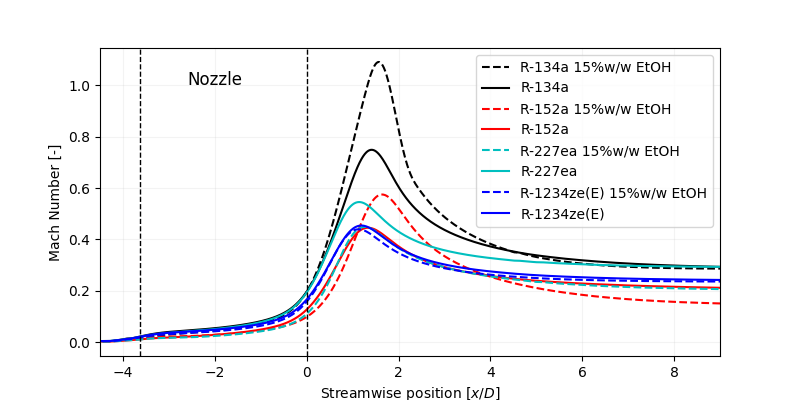

In [31]:
plot_a_variable('MachMag','Mach Number [-]')
plt.show();
plt.savefig(os.path.dirname(F)+'/Centerline_MachNumbers.pdf')

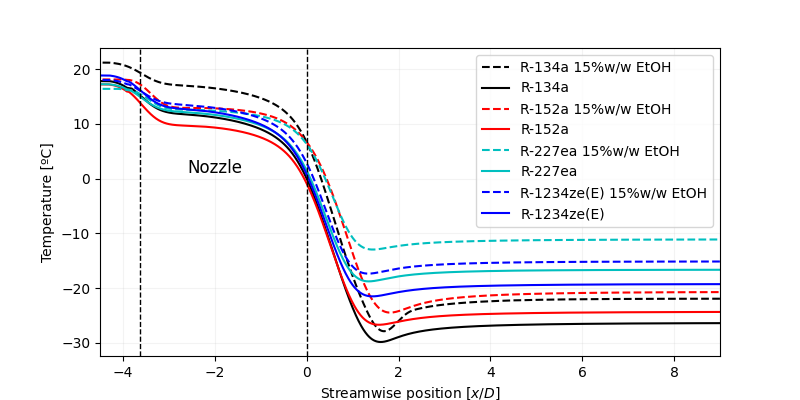

In [32]:
plot_a_variable('Tmix','Temperature [ºC]')
plt.show();
plt.savefig(os.path.dirname(F)+'/Centerline_Temperature.pdf')

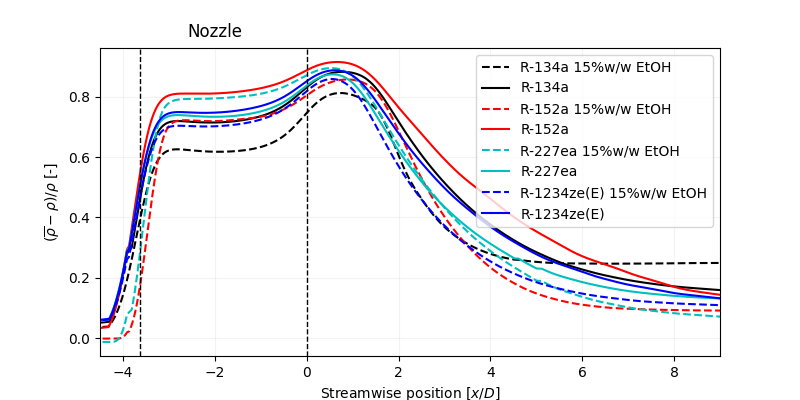

In [33]:
plot_a_variable("deltaRhoOnRho",r'$(\overline{\rho}-\rho)/ \rho$ [-]')
plt.show();
plt.savefig(os.path.dirname(F)+'/Centerline_DensityDev.pdf')

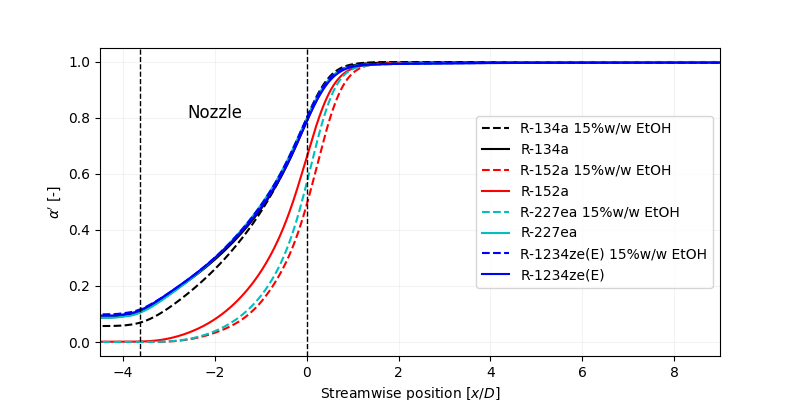

In [71]:
plot_a_variable("a['alphaFracStar']",r"$\alpha'$ [-]",0.8)
plt.legend(loc=5)
plt.show();
plt.savefig(os.path.dirname(F)+'/Centerline_AlphaFracStar.pdf')

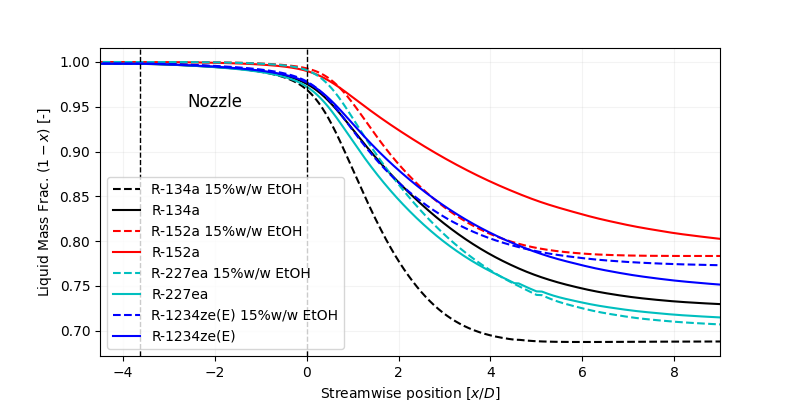

In [81]:
plot_a_variable("liqMassFrac",r"Liquid Mass Frac. $(1-x)$ [-]",.95)
#plt.ylim(0,1.05)
plt.legend(loc=3)
plt.show();
plt.savefig(os.path.dirname(F)+'/Centerline_1-x.pdf')

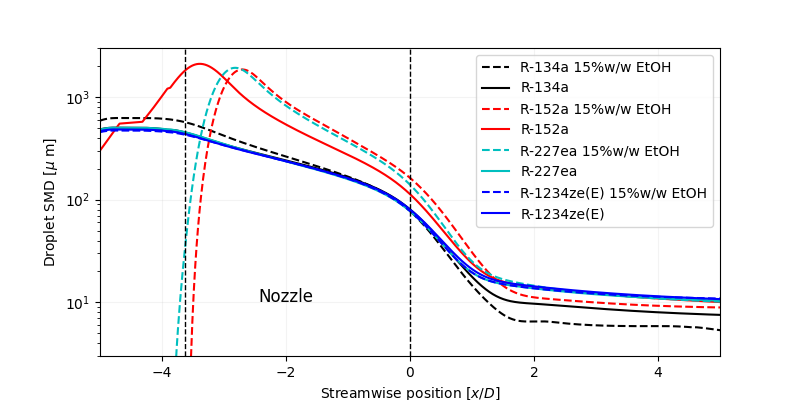

In [82]:
plot_a_variable("d32adj",r'Droplet SMD [$\mu$ m]',10)
plt.yscale('log')
plt.ylim(3,3e3)
plt.xlim(-5,5)
plt.show();
plt.savefig(os.path.dirname(F)+'/Centerline_d32.pdf')